In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

import os
os.chdir("..")
from Analysis.utils import filter_opto_data, smooth
from ms_opto_stim_protocol import OptoStimProtocol
from Style.style_guide import animal_style

def bootstrap_traces(data, sample_size=None, statistic=np.mean,
                     n_boot=1e3 ,conf_interval=95,):
    if sample_size is None:
        sample_size = data.shape[0]
    bootstrap = []
#     for i in tqdm(range(int(n_boot)),position=0,leave=True):
    for i in range(int(n_boot)):
        bootstrap.append(statistic(data[np.random.choice(np.arange(data.shape[0]),sample_size),:],axis=0))
    bootstrap = np.array(bootstrap)
    return np.mean(bootstrap,axis=0), [np.percentile(bootstrap,(100-conf_interval)/2,axis=0),
                                    np.percentile(bootstrap,conf_interval+(100-conf_interval)/2,axis=0)]

def normalized_mean(data,axis=0):
    return np.mean(data/np.mean(data,axis=1)[:,None],axis=axis)
    return np.mean(data,axis=axis)/np.mean()#data,axis=1)[:,None]

[2025-02-07 10:04:32,537][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-02-07 10:04:32,573][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


# Individual animal

In [3]:
Decoder = SortedSpikesDecodingV1
animal_list = animal_style.index.values
mua_results = {}
track_type = "lineartrack"
animal_list = ["Yoshi"]

for animal in animal_list:
    if animal in mua_results:
        continue

    dataset_key = {
        "animal": animal,
        "targeted_phase": 90,
        "track_type": track_type,
        "min_pulse_length": 20,
    }
    dataset = filter_opto_data(dataset_key)
    mua_plot = []

    nwb_file_name = dataset.fetch("nwb_file_name")[0]
    interval_list_name = dataset.fetch("interval_list_name")[0]
    encoding_tag = ""
    causal_tag = ""

    for nwb_file_name, interval_list_name in zip(
        *dataset.fetch("nwb_file_name", "interval_list_name")
    ):
        key = {
            "nwb_file_name": nwb_file_name,
            "position_group_name": interval_list_name,
            "encoding_interval": interval_list_name + encoding_tag,
        }
        query = (
            (Decoder() & key)
            & f"decoding_param_name LIKE '%{causal_tag}'"
            & "sorted_spikes_group_name NOT LIKE 'manual%'"
        )
        if not query:
            continue
        key = query.fetch1("KEY")

        opto_key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_list_name,
        }
        stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)
        test_interval = np.array(
            (OptoStimProtocol() & opto_key).fetch1("test_intervals")
        )
        mua_time = np.arange(np.min(test_interval), np.max(test_interval), 0.002)
        mua = SortedSpikesGroup().get_firing_rate(
            key, mua_time, multiunit=True, smoothing_sigma=0.005
        )

        t_on = stim_time[stim == 1]
        ind_on = np.digitize(t_on, mua_time)
        plot_ind = np.arange(-50, 50, 1)
        mua_plot.extend(
            [
                mua[ind + plot_ind]
                for ind in ind_on
                if (ind + plot_ind[0] >= 0) & (ind + plot_ind[-1] < len(mua))
            ]
        )

    if len(mua_plot) == 0:
        continue
    mua_results[animal] = np.squeeze(mua_plot)

[2025-02-07 10:04:59,216][WARNING]: Skipped checksum for file with hash: 1fb4cf78-9ee6-df68-2734-4b3c6f0f8e42, and path: /stelmo/nwb/raw/Yoshi20220513_.nwb


datasets: 2


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWa

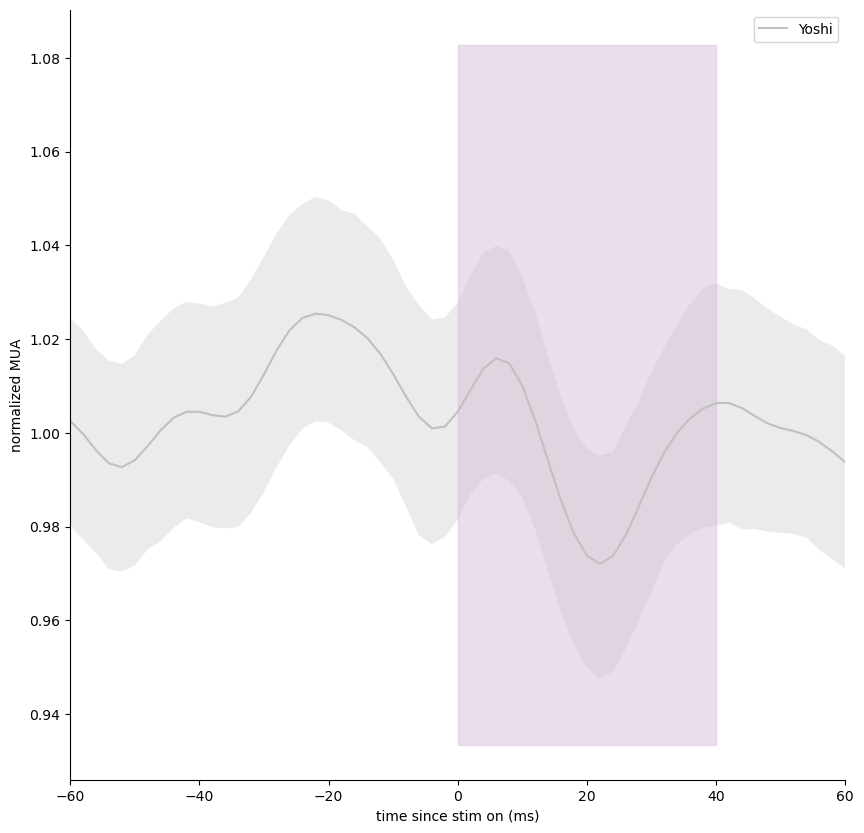

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = [fig.gca()]

lo = None
hi = None
for animal in mua_results:
    color = animal_style.loc[animal, "color"]
    mua_plot = mua_results[animal]
    plot_ind = np.arange(-50, 50, 1)

    yy, rng = bootstrap_traces(mua_plot, statistic=normalized_mean, n_boot=1e3)

    if lo is None or lo > rng[0].min():
        lo = rng[0].min()
    if hi is None or hi < rng[1].max():
        hi = rng[1].max()

    ax[0].plot(plot_ind * 2, yy, color=color, label=animal)
    ax[0].fill_between(plot_ind * 2, *rng, facecolor=color, alpha=0.3)

lo = lo * 0.99
hi = hi * 1.01


ax[0].fill_between([0, 40], [lo] * 2, [hi] * 2, color="thistle", alpha=0.5)
ax[0].legend()

for a in ax:
    a.spines[["top", "right"]].set_visible(False)
plt.xlabel("time since stim on (ms)")
ax[0].set_ylabel("normalized MUA")
plt.xlim(-60, 60)
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig('/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/mua_lineartrack_90_individual.svg',format='svg')

# group transfected and control

54

In [17]:
Decoder = SortedSpikesDecodingV1
animal_list = animal_style.index.values
mua_results = {}

for transfected in [True, False]:
    if animal in mua_results:
        continue

    dataset_key = {
        "targeted_phase": 90,
        "track_type": "lineartrack",
        "min_pulse_length": 20,
        "transfected": transfected,
    }
    dataset = filter_opto_data(dataset_key)
    mua_plot = []
    encoding_tag = ""
    causal_tag = ""
    n_units = 0

    for nwb_file_name, interval_list_name in zip(
        *dataset.fetch("nwb_file_name", "interval_list_name")
    ):
        key = {
            "nwb_file_name": nwb_file_name,
            "position_group_name": interval_list_name,
            "encoding_interval": interval_list_name + encoding_tag,
        }
        query = (
            (Decoder() & key)
            & f"decoding_param_name LIKE '%{causal_tag}'"
            & "sorted_spikes_group_name NOT LIKE 'manual%'"
        )
        if not query:
            continue
        key = query.fetch1("KEY")

        opto_key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_list_name,
        }
        stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)
        test_interval = np.array(
            (OptoStimProtocol() & opto_key).fetch1("test_intervals")
        )
        mua_time = np.arange(np.min(test_interval), np.max(test_interval), 0.002)
        mua = SortedSpikesGroup().get_firing_rate(
            key, mua_time, multiunit=True, smoothing_sigma=0.005
        )
        n_units += len(SortedSpikesGroup.fetch_spike_data(key))

        t_on = stim_time[stim == 1]
        ind_on = np.digitize(t_on, mua_time)
        plot_ind = np.arange(-50, 50, 1)
        mua_plot.extend(
            [
                mua[ind + plot_ind]
                for ind in ind_on
                if (ind + plot_ind[0] >= 0) & (ind + plot_ind[-1] < len(mua))
            ]
        )

    if transfected:
        mua_results["transfected"] = np.squeeze(mua_plot)
    else:
        mua_results["control"] = np.squeeze(mua_plot)
    print("transfected" if transfected else "control")
    print("total_units", n_units)
    print("total_stimuli", len(mua_plot))

[2025-02-07 10:43:54,355][WARNING]: Skipped checksum for file with hash: 1f5c50a7-0065-fa56-18eb-45182d0fa2f5, and path: /stelmo/nwb/raw/Frodo20230810_.nwb


datasets: 11


[2025-02-07 10:43:55,954][WARNING]: Skipped checksum for file with hash: 6d808fc5-4451-72e0-8008-5d012e52bddf, and path: /stelmo/nwb/raw/Frodo20230811_.nwb
[2025-02-07 10:43:57,456][WARNING]: Skipped checksum for file with hash: 7ed2c389-5010-5a81-4934-91cc2b37f8d4, and path: /stelmo/nwb/raw/Totoro20220607_.nwb
[2025-02-07 10:44:03,722][WARNING]: Skipped checksum for file with hash: 7ed2c389-5010-5a81-4934-91cc2b37f8d4, and path: /stelmo/nwb/raw/Totoro20220607_.nwb
[2025-02-07 10:44:08,468][WARNING]: Skipped checksum for file with hash: 9d8a5a49-96aa-de26-7e0c-7f0069c6677d, and path: /stelmo/nwb/raw/Winnie20220717_.nwb
[2025-02-07 10:44:11,329][WARNING]: Skipped checksum for file with hash: 9d8a5a49-96aa-de26-7e0c-7f0069c6677d, and path: /stelmo/nwb/raw/Winnie20220717_.nwb
[2025-02-07 10:44:13,934][WARNING]: Skipped checksum for file with hash: 7084610d-1911-ec9c-98b6-21f865ff9efd, and path: /stelmo/nwb/raw/Bilbo20230725_.nwb


transfected
total_units 583
total_stimuli 5143
datasets: 7


[2025-02-07 10:44:15,727][WARNING]: Skipped checksum for file with hash: eaf52893-1419-fe04-2ba5-a2b8ea80f655, and path: /stelmo/nwb/raw/Olive20220707_.nwb
[2025-02-07 10:44:17,674][WARNING]: Skipped checksum for file with hash: eaf52893-1419-fe04-2ba5-a2b8ea80f655, and path: /stelmo/nwb/raw/Olive20220707_.nwb
[2025-02-07 10:44:20,164][WARNING]: Skipped checksum for file with hash: 4b5f77e9-2131-4188-245b-00b7ae3f6801, and path: /stelmo/nwb/raw/Wallie20220914_.nwb
[2025-02-07 10:44:24,233][WARNING]: Skipped checksum for file with hash: 4b5f77e9-2131-4188-245b-00b7ae3f6801, and path: /stelmo/nwb/raw/Wallie20220914_.nwb
[2025-02-07 10:44:28,550][WARNING]: Skipped checksum for file with hash: 1fb4cf78-9ee6-df68-2734-4b3c6f0f8e42, and path: /stelmo/nwb/raw/Yoshi20220513_.nwb
[2025-02-07 10:44:32,166][WARNING]: Skipped checksum for file with hash: 1fb4cf78-9ee6-df68-2734-4b3c6f0f8e42, and path: /stelmo/nwb/raw/Yoshi20220513_.nwb


control
total_units 499
total_stimuli 4815


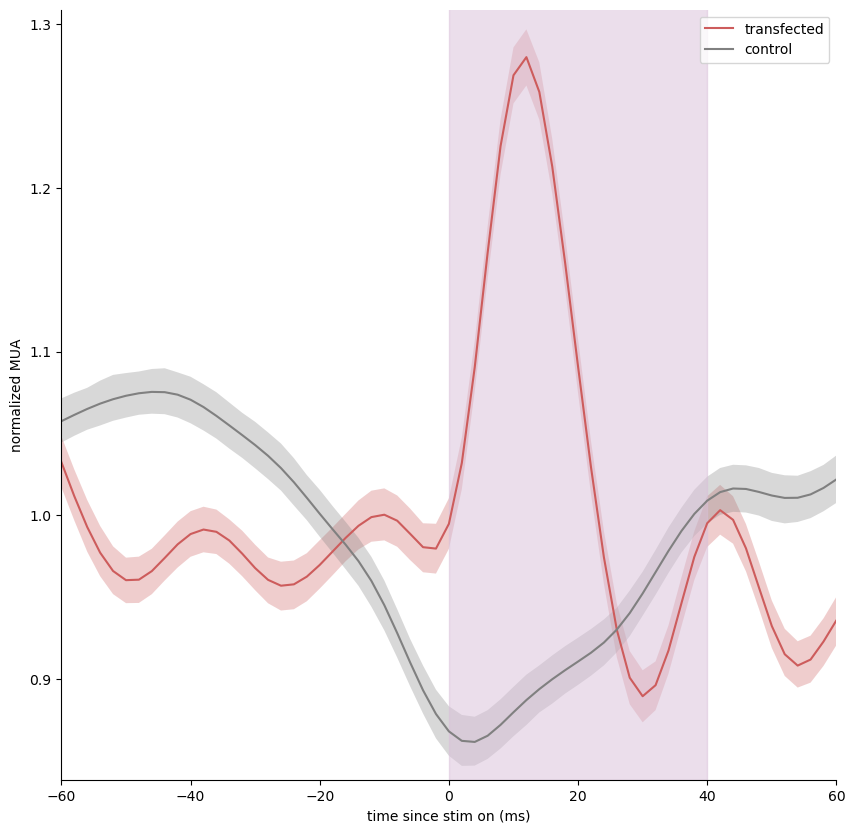

In [ ]:
from Style.style_guide import transfection_style

fig = plt.figure(figsize=(10, 10))
ax = [fig.gca()]

lo = None
hi = None
for animal in mua_results:
    if animal == "non-transfected":
        color = transfection_style["control"]
    else:
        color = transfection_style[animal]
    mua_plot = mua_results[animal]
    plot_ind = np.arange(-50, 50, 1)
    # add mua
    yy = np.squeeze(np.mean(mua_plot, axis=0)) / np.mean(mua_plot)
    rng = np.squeeze(
        np.std(mua_plot / np.mean(mua_plot), axis=0)
    )  # /np.sqrt(mua_plot.shape[0])
    rng = [yy - rng, yy + rng]

    yy, rng = bootstrap_traces(mua_plot, statistic=normalized_mean, n_boot=1e3)

    if lo is None or lo > rng[0].min():
        lo = rng[0].min()
    if hi is None or hi < rng[1].max():
        hi = rng[1].max()

    ax[0].plot(plot_ind * 2, yy, color=color, label=animal)
    ax[0].fill_between(plot_ind * 2, *rng, facecolor=color, alpha=0.3)

lo = lo * 0.99
hi = hi * 1.01


ax[0].fill_between([0, 40], [lo] * 2, [hi] * 2, color="thistle", alpha=0.5)
ax[0].legend()

for a in ax:
    a.spines[["top", "right"]].set_visible(False)
plt.xlabel("time since stim on (ms)")
ax[0].set_ylabel("normalized MUA")
ax[0].set_ylim(lo, hi - 0.001)
plt.xlim(-60, 60)

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig('/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/mua_lineartrack_90_grouped.svg',format='svg')

In [16]:
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("./Plots/mua_normalized_grouped.svg", format="svg")

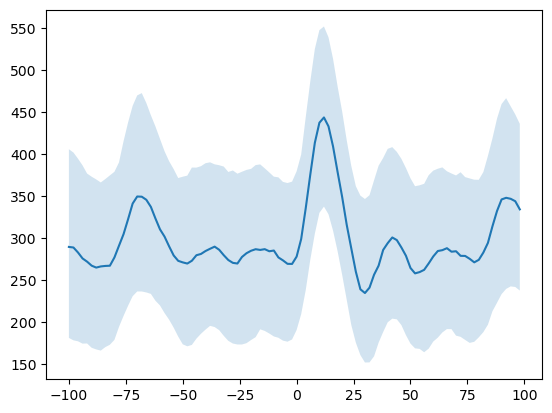

In [32]:
mid = np.median(mua_plot, axis=0)
lo = np.squeeze(np.percentile(mua_plot, 25, axis=0))
hi = np.squeeze(np.percentile(mua_plot, 75, axis=0))
plt.plot(plot_ind * 2, mid)
plt.fill_between(plot_ind * 2, lo, hi, alpha=0.2)

In [20]:
lo.shape

(100, 1)